<a href="https://colab.research.google.com/github/noah-beniteznelson/recharge_deficit/blob/main/hydrograph_recession_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- [![DOI](https://zenodo.org/badge/357586333.svg)](https://zenodo.org/badge/latestdoi/357586333) -->

Change DOI HERE

#**Comparing method of fitting hydrograph recessions with the sensitivity function**
---
Estimating groundwater recharge with the sensitivity function requires fitting $g(Q)$ when recharge and transpiration from groundwater are sufficiently low compared to discharge (Kirchner 2009).  To avoid $E_{gw} \gg Q$, we follow Dralle et al. (2018) in restricting the streamflow recessions used to fit $g(Q)$ from November-March.  Winter energy-limitation in California's seasonal Mediterranean climate causes discharge to greatly exceed the rate of evapotranspiration across the study sites.  However, we diverge from the common practice of excluding streamflow recessions during days with significant rainfall to ensure $P,R\ll Q$ (Kirchner, 2009; Dralle et al., 2018; Wlostowski et al., 2023; Dralle et al., 2023).  For the extended streamflow timeseries fit in our analysis ($\geq$10 years in each watershed), we reason the impact of small-event recharge on recession behavior will be averaged-out by recessions within the same range of $Q$ for which recharge did not occur.  This yields a more extensive timeseries for fitting the sensitivity function and allows us to capture the steepest streamflow recessions.  However, we still remove the first and last days of individual recessions to negate the greatest contributions from recharge at the limits of the recession duration.  Here, we show the difference in our method of extracting and fitting streamflow recessions to that described in Dralle et al. (2023) at the original Elder Creek catchment.

---

Created for *Patterns of Intra-Seasonal Groundwater Recharge Inferred from Streamflow and Explained by Vadose Zone Storage Deficits*.

**Load packages.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
import warnings
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import r2_score
%config InlineBackend.figure_format = 'retina'

**Mount Google Drive.** For running analyses in GoogleColab, save and  import datasets to/from selected folder in Google Drive.  To mount Drive, find the file name of the folder you wish to connect to.  By default, files are saved to user's "My Drive" dashboard.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)  # Change folder name here

Mounted at /content/drive


**Load data.**  Load corrected catchment data and summary table (as .csv files) from Google Drive.

In [ ]:
path = "/content/drive/My Drive/recharge_deficit/"

# Extracted catchment data
df_extr = pd.read_csv(path + "extracted_catchment_data.csv")
df_extr.set_index('Unnamed: 0',inplace=True,drop=True)
df_extr.index=pd.to_datetime(df_extr.index)

# Corrected catchment hydrologic data
df_gages = pd.read_csv(path + "filtered_catchment_data.csv")
df_gages.set_index('Unnamed: 0',inplace=True,drop=True)
df_gages.index=pd.to_datetime(df_gages.index)

**Define the recharge method used in the analysis.**  Include option to show calculation using rainless recession.

In [ ]:
# Kirchner (2009) binning function
def KirchnerBinning(df, binning, min_per_bin=10, loud=False):
  df = df.sort_values('q',ascending=False)
  logQ = np.array(np.log(df.q))
  logRange = np.max(logQ) - np.min(logQ)
  minBinSize = logRange*.01
  binBoundaries = [0]
  for i in range(1,len(df)):
      if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize:
          if loud: print('Bin too small')
          continue
      if abs(i-binBoundaries[-1]) < min_per_bin:
          if loud: print('Not enough data points')
          continue
      curr = df.loc[binBoundaries[-1]:i,binning]
      if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2:
          if loud: print('Bin too heterogeneous')
          continue
      binBoundaries.append(i)
  return binBoundaries

# Function to derive the sensitivity function and calulate recharge
def calc_recharge(df,gage,ax,rainless=False,title=None):
  """
  Calculate and returns recharge for catchment using DataFrame of hydrologic
  values.  Plot log(dQ/dt) vs. log(Q) on specified axis object. Optional
  averaging is not recommended and set to 'None' by default.
  @params:
    df (:obj:`df`): DataFrame containing catchment hydrology
    gage (:obj:`str`): USGS 8-number gage station ID
    ax (:obj:`axes`): Matplotlib axes object for plotting
    title (:obj:`str`): Optional title for plot
    rainless (:obj:'bool'):  When true, clalculate recharge excluding
                             non-negligible rainfall
  @returns:
    df_recharge (:obj:`df`):   DataFrame containing recharge [mm]
  """
  # Redefine gage data
  df_gage = df.filter(regex=".*%s"%gage).join(df[['date','wateryear']])
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index=pd.to_datetime(df_gage.index)

  # Long-term discharge mean over all available data from analysis months (November-March)
  df_winter = df_gage[df_gage.index.month.isin([11,12,1,2,3])]
  meanQ = np.mean(df_winter.q)

  # Create lists to store discharge (qs) and its derivative (dqs)
  mean_fraction = 0.001 # mm/day
  lag = 1 # days
  qs = []
  dqs = []

  # Iterate through water year winter streamflow recessions (method used in analysis)
  if rainless==False:
    for wateryear,group in df_winter.groupby('wateryear'):
      group = group.dropna(subset='q')
      if len(group) < 100:
        continue
      runoff = np.array(group.q)
      dq = np.diff(runoff)
      # Find recession periods (index of start and stop)
      idx = np.where(dq<0)[0]
      groups = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
      if len(groups)>1:
        periods = [[group[0], group[-1]] for group in groups]
      else:
        continue
      # Calculate dq/dt
      for recession in periods:
        start = recession[0]+1
        stop = recession[1]
        # Check for recessions > 2 days
        if (stop-start)<1:
          continue
        for i in range(start, stop):
          q_diffs = runoff[start] - runoff[i+1:stop]
          idx_end = np.where(q_diffs>mean_fraction*meanQ)[0]
          if len(idx_end)>0:
            idx_end = idx_end[0]
            qs.append((runoff[i] + runoff[i+idx_end+1])/2)
            dqs.append((runoff[i+idx_end+1]-runoff[i])/(idx_end+1))
          else:
            continue
  # Iterate through water year rainless winter streamflow recessions (original method)
  else:
    rainfall_lag = 1
    for wateryear, group in df_winter.groupby('wateryear'):
      # Do not loop beyond the 2020 water year
      if wateryear>2020:
          continue
      rain = np.array(group.ppt)
      runoff = np.array(group.q)
      # Attempt to calulate qs and dqs, continue if no discharge
      i = rainfall_lag
      while i <len(rain):
        # Check for storm events exceeding 2 mm/day
        if np.sum(rain[i-rainfall_lag:i+1]) > 2:
          i+=1
          continue
        # Find index of next day of rainfall
        idx_next_rain = np.where(rain[i+1:]>0)[0]
        if len(idx_next_rain)>0:
            idx_next_rain = idx_next_rain[0] + (i+1)
        else: # No more rain in winter months
            break
        # Check rainless period length
        if idx_next_rain==i+1:
          i+=2
          continue
        # Calculate dQ/dt, not including the next day of rainfall
        for j in range(i, idx_next_rain):
            q_diffs = runoff[j] - runoff[j+1:idx_next_rain]
            idx_end = np.where(q_diffs>mean_fraction*meanQ)[0]
            if len(idx_end)>0:
                idx_end = idx_end[0]
                qs.append((runoff[j] + runoff[j+idx_end+1])/2)
                dqs.append((runoff[j+idx_end+1]-runoff[j])/(idx_end+1))
            else:
                i = idx_next_rain + rainfall_lag + 1
                break
        i = idx_next_rain + rainfall_lag + 1

  # Append to list
  qs = np.array(qs)
  dqs = np.array(dqs)

  # Plot raw data
  ax.scatter(np.log(qs), np.log(-dqs), label="raw", s=1, color='lightgray', zorder=-2)

  # Sort qs and eps in descending order and calculate bin boundaries using Kirchner binning
  df_kirchner = pd.DataFrame({'q':qs, 'dq':dqs})
  df_kirchner = df_kirchner.sort_values('q',ascending=False)
  binBoundaries = KirchnerBinning(df_kirchner, binning='dq', min_per_bin=10)

  # Calculate mean discharge, mean adjusted recession rate, and standard errors for each bin
  qs = np.array([np.mean(df_kirchner.q[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
  dqs = np.array([np.mean(df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
  sigmas = np.array([np.std(np.log(-df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]].loc[df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]<0]))/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)]) + 1e-12

  # # Remove bins with infinitely small (~0) standard error
  error_idx = sorted([i for i in range(len(sigmas)) if sigmas[i] < 1e-2], reverse=True)
  qs = np.delete(qs,error_idx)
  dqs = np.delete(dqs,error_idx)
  sigmas = np.delete(sigmas,error_idx)

  # Create a scatter plot of log(qs) and log(-dq) with error bars, fitted line
  ax.errorbar(np.log(qs), np.log(-dqs), label="binned", yerr=sigmas, fmt='o', capsize=2, **{'ms':3, 'mfc':'limegreen','zorder':-1})

  # Wlowtoski et al. (2020) sensitivity function
  logqbar = np.log(np.mean(qs))
  logsigma = np.log(np.std(qs))
  def bQ(q,bl,bu):
    return bl + (bu - bl)*0.5*(1 + scipy.special.erf((np.log(q) - logqbar))/(logsigma*np.sqrt(2)))
  def logeps(q,bl,bu,a): # Log transformation
    return np.log(a) + bQ(q,bl,bu)*np.log(q/np.mean(q))
  def eps(q,bl,bu,a):
    qbar = np.exp(logqbar)
    return a*(q/qbar)**bQ(q,bl,bu)
  def g(q,p):
    return eps(q, *p)/q

  # Fit dynamic power function with log transformation
  popt, pcov = curve_fit(logeps, qs, np.log(-dqs), sigma=sigmas**2, maxfev=2000)
  coefficient_of_determination = r2_score(np.log(-dqs), logeps(qs, *popt))
  ax.plot(np.log(qs), logeps(qs, *popt), label=r"$\mathrm{R^2}$ = %.2f"%coefficient_of_determination, lw=2, zorder=-1)

  # Axis labels, title
  ax.set(xlabel='ln(Q) [mm/day]', ylabel=r'$\ln(\frac{dQ}{dt})$ [mm/day$^2$]')
  if title!=None:
    ax.set_title(title,fontsize=12)

  # Add legend, change order of items
  handles, labels = ax.get_legend_handles_labels()
  order = [1,2,0]
  legend = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=8, loc='upper left')
  # legend.set_frame_on(False)
  legend.legend_handles[2]._sizes =[6]

  ## Hydrograph recession following Dralle et al. (2023)
  # Create a new DataFrame to store recharge
  df_recharge = pd.DataFrame(columns = ['rt_%s'%gage])

  # Iterate through water years and calculate recharge for each year
  for wateryear, group in df_gage.groupby('wateryear'):
    # Temporary DataFrame to store recharge in loop
    df_temp = pd.DataFrame()
    # Calculate direct storage (recharge), assuming 0 at start of wet season
    qvar = group.q.tolist()
    rts = [0]
    for i in range(1,len(qvar)):
      dt = 1.0
      qi = qvar[i]
      qi1 = qvar[i-1]
      # Check for no-flow condition
      rt = 0 if qi == 0 or qi1 == 0 else (qi - qi1)/dt/((g(qi,popt) + g(qi1,popt))/2) + (qi+qi1)/2
      rts.append(rt)

    rts = np.array(rts)
    rts[rts<0] = 0

    # Skip wateryears missing 10% of data
    df_temp['rt_%s'%gage] = rts if len(group) > 324 else np.full(len(group),np.nan)
    df_recharge = pd.concat([df_recharge,df_temp])

  # Assign index to recharge DataFrame
  df_recharge['rt_%s'%gage] = df_recharge['rt_%s'%gage].astype(float)
  df_recharge['date'] = df_gage.index
  df_recharge.set_index('date',inplace=True)
  return df_recharge

**Show difference between method used in analysis and rainless recession method.**

<ipython-input-6-223419650379>:156: RuntimeWarning: invalid value encountered in log
  return np.log(a) + bQ(q,bl,bu)*np.log(q/np.mean(q))
<ipython-input-6-223419650379>:156: RuntimeWarning: invalid value encountered in log
  return np.log(a) + bQ(q,bl,bu)*np.log(q/np.mean(q))


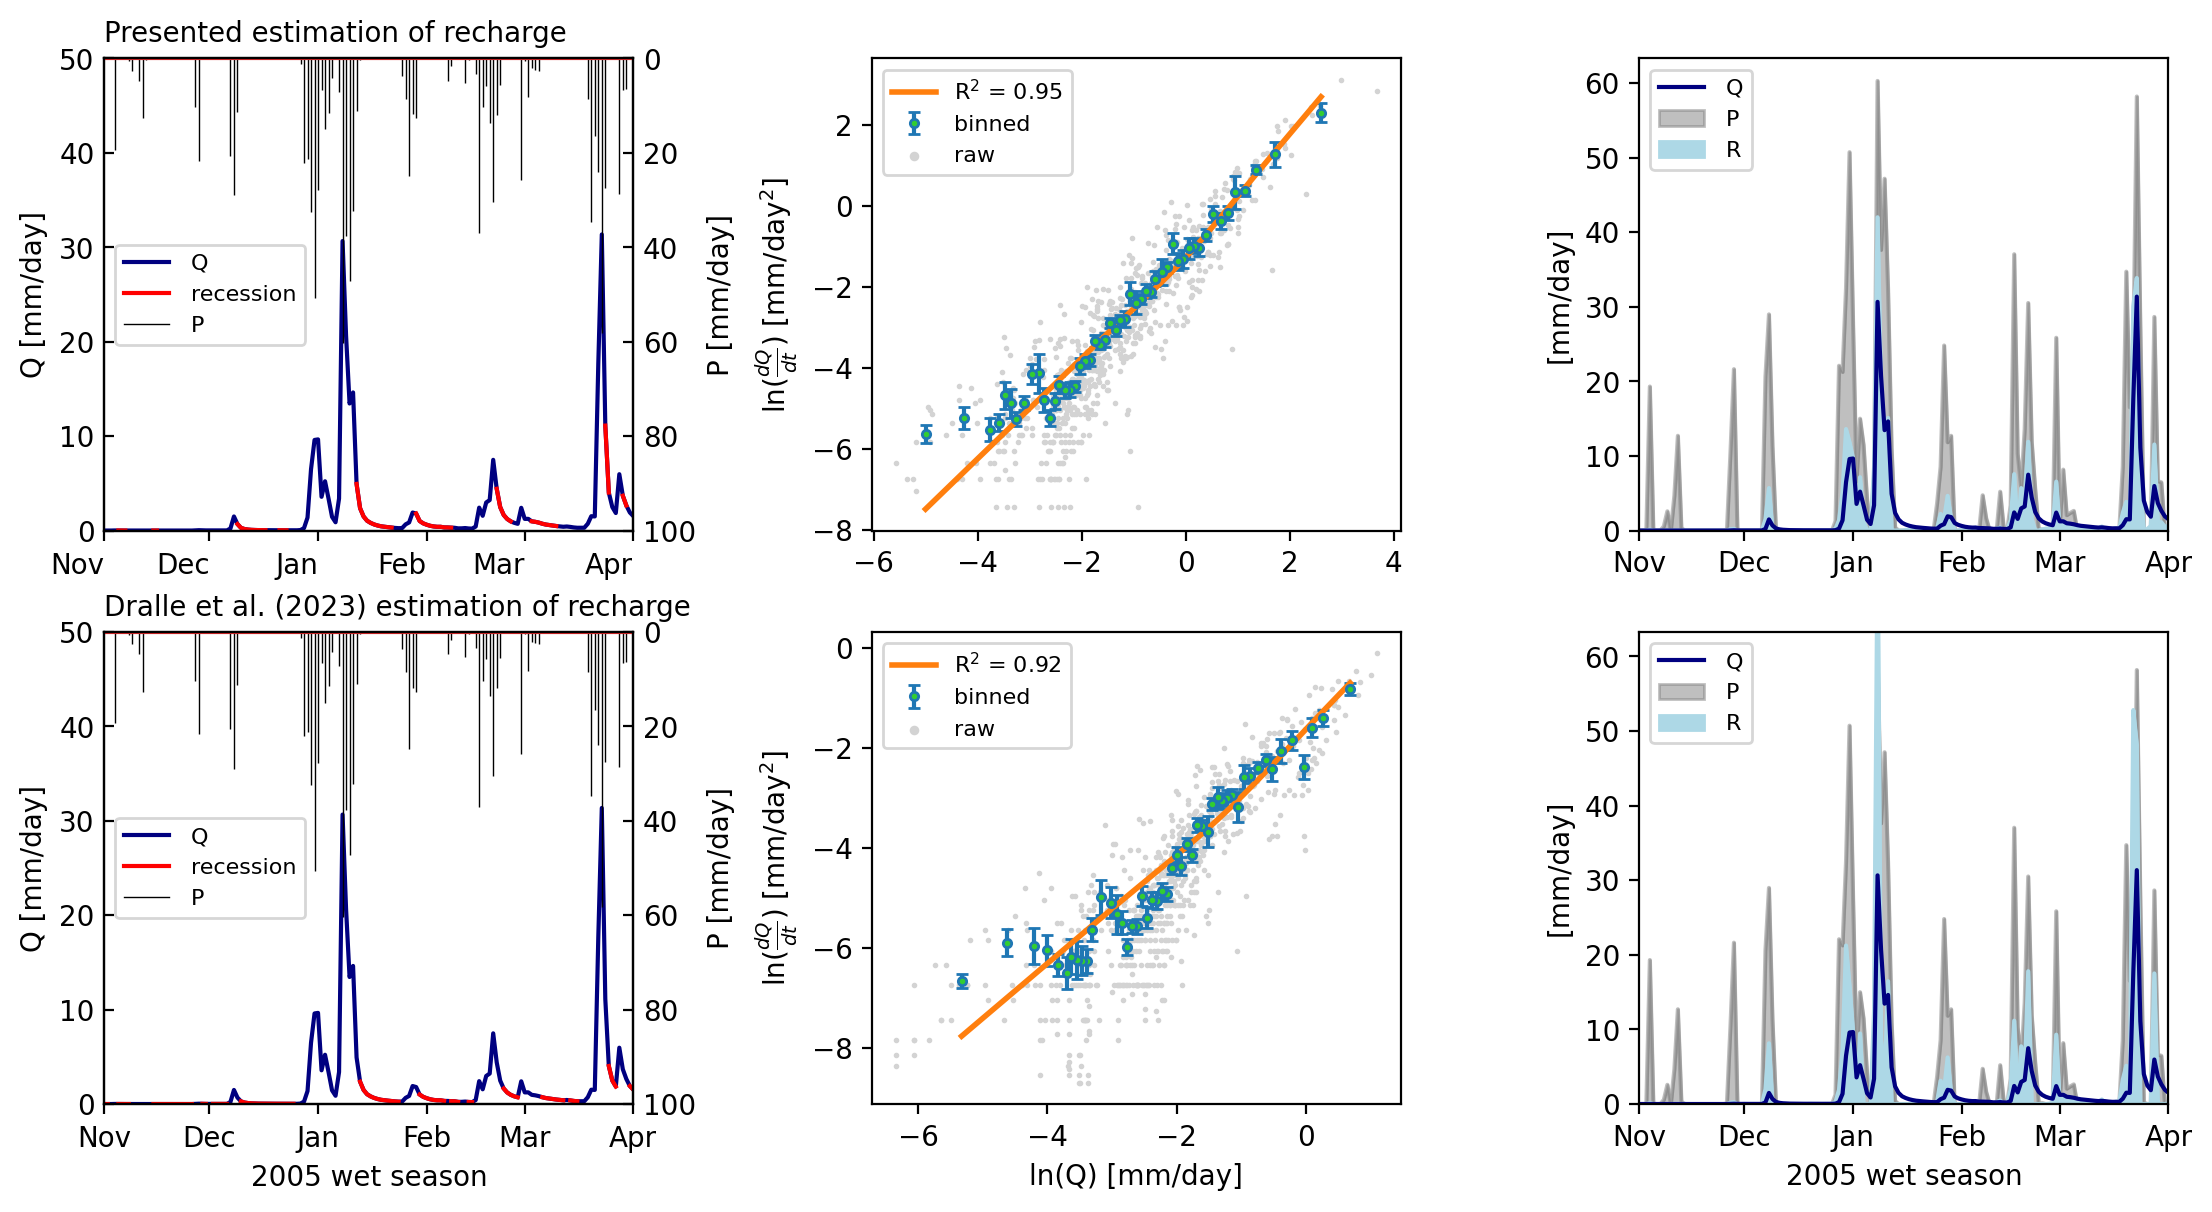

In [ ]:
# Define gage, wateryear
gage = '11284400'
wateryear=2005

# Plotting space
fig,axs = plt.subplots(2,3,figsize=(11,6))

# Extract gage data from combined DataFrame
df_gage = df_gages.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']])
df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
df_gage.set_index('date', inplace=True)
df_gage.index = pd.to_datetime(df_gage.index)

# Water year winter hydrology
df_winter = df_gage.loc['%s-11-01'%str(wateryear-1):'%s-04-01'%str(wateryear)]

## Left panels:
# Hydrograph recession, our method
datetime = np.array(df_winter.index)
runoff = np.array(df_winter.q)
dq = np.diff(runoff)
idx = np.where(dq<0)[0]
groups = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
periods = [[group[0], group[-1]] for group in groups]
for recession in periods:
  start = recession[0]+1
  stop = recession[1]
  # Check for recessions > 2 days
  if (stop-start)>0:
    axs[0,0].plot(datetime[start:stop], runoff[start:stop], color='red', zorder=2)

# Hydrograph recession, rainless method
df_recession = df_winter.loc[:,['q','ppt']]
df_recession[df_recession.ppt>2] = np.nan
df_recession[df_recession.q.diff()>0] = np.nan
df_recession.plot(y='q', legend=False, color='red', ax=axs[1,0], zorder=2)

# Hydrograph and precipitation
for row in [1,0]:
  # Winter hydrograph
  ax = axs[row,0]
  df_winter.plot(y='q', legend=False, color='navy', ax=ax, zorder=-1)
  # Precipitation
  twinx = ax.twinx()
  stem = twinx.stem(df_winter.index, df_winter.ppt, 'k', markerfmt='')
  plt.setp(stem[1], 'linewidth', 0.5)
  plt.setp(stem[1], 'zorder', -2)
  twinx.invert_yaxis()
  # Axis labels, limits
  if row==0:
    ax.set_xlabel("")
  else:
    ax.set_xlabel('%s wet season'%str(wateryear))
  ax.set(ylabel="Q [mm/day]", ylim=[0,50])
  twinx.set(xlabel="", ylabel='P [mm/day]', ylim=[100,0])
  ax.autoscale(enable=True, axis='x', tight=True)
  # Axis tick marks
  ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  ax.minorticks_off()
  ax.tick_params(axis='x', which='major', pad=4, rotation=0)
  ax.tick_params('y', direction='in')
  twinx.tick_params('y', direction='in')
  # Legend handling
  Q_line = matplotlib.lines.Line2D([],[],color='navy', label='Q')
  recession_line = matplotlib.lines.Line2D([],[],color='red', label='recession')
  P_line = matplotlib.lines.Line2D([],[], color='k', lw=0.5, label='P')
  twinx.legend(handles=[Q_line,recession_line,P_line], loc='center left', fontsize=8, handletextpad=1, framealpha=0.8)

## Middle panels (sensitivity function)
# Sensitivity function
df_recharge = calc_recharge(df_gages, gage, ax=axs[0,1])
df_recharge_rainless = calc_recharge(df_gages, gage, ax=axs[1,1], rainless=True)
axs[0,1].set_xlabel("")

# Recharge ramp
for row in [1,0]:
  ax = axs[row,2]
  # Winter discharge and precipitation
  df_winter.plot(y='q', label='Q', color='navy', ax=ax, zorder=0)
  df_winter.plot(y='ppt', label='P', kind='area', color='gray', alpha=0.5, ax=ax, zorder=-2)
  # Winter recharge
  df = df_recharge if row==0 else df_recharge_rainless
  df_winter_rt = df.loc['%s-11-01'%str(wateryear-1):'%s-04-01'%str(wateryear)]
  df_winter_rt.plot(y='rt_%s'%gage, label='R', kind='area', color='lightblue', alpha=1, ax=ax, zorder=-1)
  # Legend handling
  ax.legend(loc='upper left', fontsize=8, handletextpad=1)
  # Axis formatting
  ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  ax.minorticks_off()
  xlabel="%s wet season"%str(wateryear) if row==1 else ""
  ax.set(xlabel=xlabel,ylabel="[mm/day]")

# Title handling
axs[0,0].set_title("Presented estimation of recharge", loc='left', fontsize=10)
axs[1,0].set_title("Dralle et al. (2023) estimation of recharge", loc='left', fontsize=10)

# Tighten layout
fig.tight_layout(pad=0.5)

#**References**
Dralle, D. N., Hahm, W. J., Rempe, D. M., Karst, N. J., Thompson, S. E., & Dietrich, W. E. (2018). Quantification of the seasonal hillslope water storage that does not drive streamflow. Hydrological processes, 32(13), 1978-1992.

Dralle, D. N., Hahm, W. J., & Rempe, D. (2023). Inferring hillslope groundwater recharge ratios from the storage-discharge relation. Geophysical Research Letters, 50 (14).

Kirchner, J. W. (2009). Catchments as simple dynamical systems: Catchment characterization, rainfall‐runoff modeling, and doing hydrology backward. Water Resources Research, 45(2).

Wlostowski, A. N., Molotch, N., Anderson, S. P., Brantley, S. L., Chorover, J., Dralle, D., ... & Harman, C. (2021). Signatures of hydrologic function across the critical zone observatory network. Water Resources Research, 57(3), e2019WR026635.